# Who survived Titanic?
This report investigates common traits among the survivors and the fatalities of the sinking of the Titanic.

This analysis seek to give an indicative answer to the following question:

**Are gender, ticket class, embarkation point or age related to survival rate?**

The findings do not include statistics, and are only to be regarded as tentative.

Code to retrieve the data is included below. The datatypes are printed to give a quick overview. For a more detailed data explanation see:
https://www.kaggle.com/c/titanic/data

In [32]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
%matplotlib
%matplotlib inline
plt.style.use('seaborn-muted')
df_raw = pd.read_csv('titanic-data.csv')
print(df_raw.dtypes)


Using matplotlib backend: Qt5Agg
PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object


## Data cleaning
Data is checked for missing observations.

In [33]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


The variable "Age" only includes 714 observations, while there are 891 passenger ID's. Due to these miissing 177 observations, some care is needed when interpreting this variables relation to rate of survival.
These observations are not removed, as the relation between the variable age and the others are not needed in the analysis below.

For readability of visualisations, more columns are created with more easy to interpret observational names.

In [34]:
df_raw['Survival'] = df_raw.Survived.map({0 : 'Died', 1 : 'Survived'})
df_raw['Class'] = df_raw.Pclass.map({1 : 'First Class', 2 : 'Second Class', 3 : 'Third Class'})
df_raw['Ports'] = df_raw.Embarked.map({'C' : 'Cherbourg', 'Q' : 'Queenstown', 'S' : 'Southampton'})

For graphical purposes, the "Age" variable is split into bins by rounding to the nearest multiple of 10.

In [35]:
def round_age(x):
    y = np.around(x/10) * 10
    return y
df_age_rounded = df_raw[['Age', 'Survival']].copy()
df_age_rounded['Age'] = df_age_rounded['Age'].apply(round_age)


## Breakdown of the total number of passengers
This part includes visualizations of the total number of passengers on Titanic, split on different variables of interes.

PassengerId's to be investigated:  0

Passengers:  891
Survived:  342
Fatalitites:  549


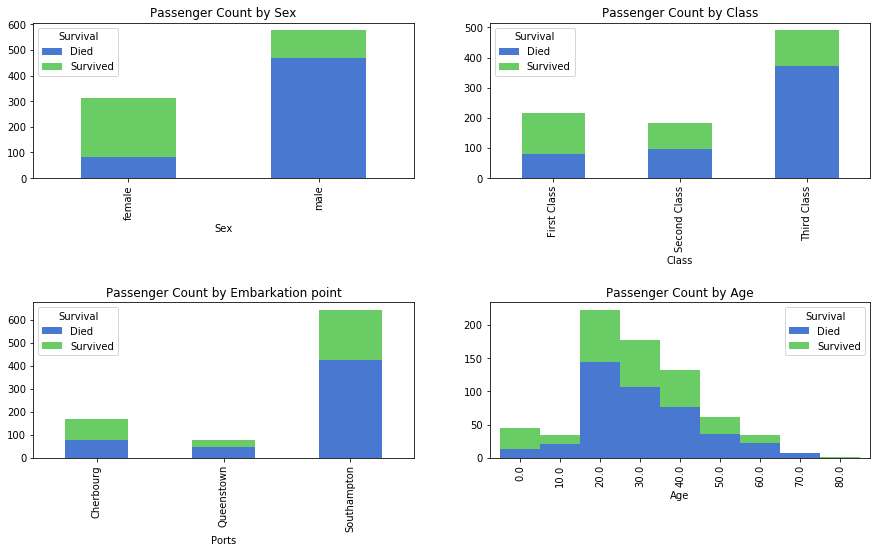

In [36]:
Total_passengers = df_raw['PassengerId'].value_counts()
print("PassengerId's to be investigated: ", np.sum(Total_passengers > 1))
print('')
total = np.sum(Total_passengers, axis=0)
survivors = df_raw['Survived'].sum()
fatalities = total - survivors
print("Passengers: ", total)
print('Survived: ', survivors)
print('Fatalitites: ', fatalities)

fig, axs = plt.subplots(2, 2, figsize=(15, 8))
df_sex = df_raw.groupby(["Sex", "Survival"]).size().unstack()
df_class = df_raw.groupby(["Class", "Survival"]).size().unstack()
df_emb = df_raw.groupby(["Ports", "Survival"]).size().unstack()
df_age = df_age_rounded.groupby(["Age", "Survival"]).size().unstack()

plt_sex = df_sex.plot(
    kind='bar',
    ax=axs[0, 0],
    title='Passenger Count by Sex',
    stacked=True)
plt_class = df_class.plot(
    kind='bar',
    ax=axs[0, 1],
    title='Passenger Count by Class',
    stacked=True)
plt_emb = df_emb.plot(
    kind='bar',
    ax=axs[1, 0],
    title='Passenger Count by Embarkation point',
    stacked=True)
plt_age = df_age.plot(
    kind='bar',
    ax=axs[1, 1],
    title='Passenger Count by Age',
    stacked=True,
    width=1)

fig.subplots_adjust(hspace=.8)


First, a check is performed that passenger ID's are only included once. This turns out to be the case. If it wasn't, data would have had to be tweaked before the calculation of the visualizations.

Note: Survived=0 (blue bars in the charts) show the total number of perished persons in each breakdown. Survived=1 (green bars in the charts) shows the number of persons who survived.

### Total passengers
In total, the data shows 891 unique passenger ID's. 342 of these survived and 549 perished.
From the site https://en.wikipedia.org/wiki/Sinking_of_the_RMS_Titanic it is possible to gather that an estimated 2,224 persons were aboard, of which more than 1,500 died. This data can thus be seen as a sample of the population aboard the Titanic.

### Passengers by sex
Of the passengers aboard, a little less than 2/3 where male and a little more than 1/3 were female. It appears that a larger fraction of men than women perished in the disaster. This will be investigated further, later.

### Passengers by class
Of the passengers, about 200 were travelling first class, 200 second class and 500 third class. The mortality among third class appears to have been higher than for second and first class. Due to the dominant size of the third class in the graph, it is difficult to make out whether or not there is a large difference between the second and first class.
As the total number for each class sum to the total number of unique passenger ID's, it can be concluded that this sample only includes passengers. As there were about 885 crew members aboard (see earlier link to Wikipedia article), this sample of the total population aboard Titanic is therefore clearly not representative, as being a crew member might have affected the chances of surviving. It might still be representative of the total population of passengers aboard Titanic.

### Passengers by embarkation point
Titanic took passengers on board in Cherbourg (C) in France, Southampton (S) in England and Queenstown (Q) in Ireland (England and Ireland were both parts of The United Kingdom of Great Britain and Ireland at the time). The bulk of the passengers (about 600) boarded at Southampton. It is difficult to distinguish whether embarkation point had any influence on the likelihood of survival.

### Passenger by age
The ages have been rounded to the nearest multiple of 10.
The majority of passengers were between 15 and 45 years old.


## Mortality rates among passengers
The visuzalitions in the preceding chapter presented the absolute numbers. But from these, it can be difficult to understand which charateristics appears related to the chance of surviving.
Therefore, the percentage who survived and perished for each of the above breakdowns are calculated.

Average Survival Rate:  0.38
Average Mortality Rate:  0.62


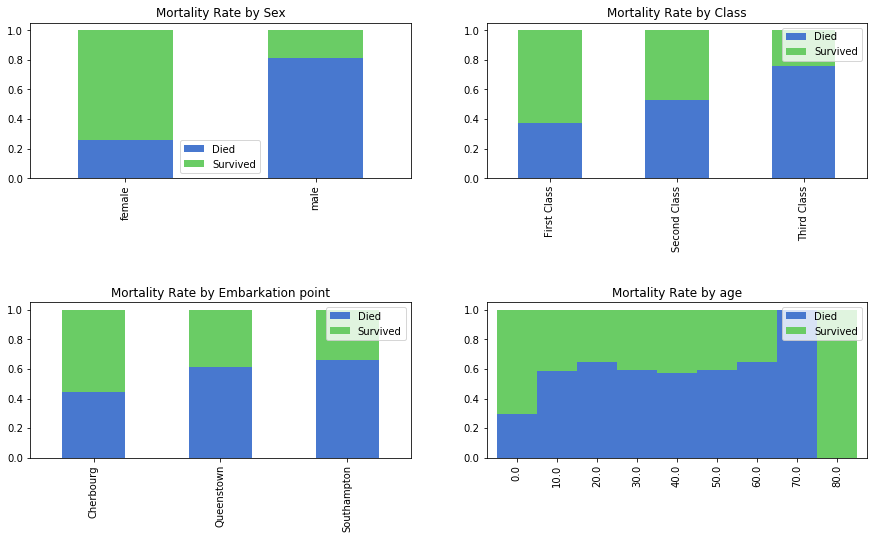

In [37]:
def calc_pct(df):
    '''Takes grouped but unstacked dataframe and its rowwisepercentages
    Input: df        A dataframe of a grouped but unstacked dataframe.
    Ouput: df_pct    A dataframe with percentages, row wise.
    '''
    df_pct = pd.DataFrame()
    for row in df.index:
        for column in df.columns:
            pct = df.loc[row, column] / df.loc[row, :].sum()
            df_pct.loc[row, column] = pct
    return df_pct

df_sex_pct = calc_pct(df_sex)
df_class_pct = calc_pct(df_class)
df_age_pct = calc_pct(df_age)
df_emb_pct = calc_pct(df_emb)

total_survival_rate = survivors/total
total_mortality_rate = fatalities/total

print("Average Survival Rate: ", np.around(total_survival_rate, decimals=2))
print("Average Mortality Rate: ", np.around(total_mortality_rate, decimals=2))

fig, axs = plt.subplots(2, 2, figsize=(15, 8))
plt_sex_pct = df_sex_pct.plot(
    kind='bar',
    ax=axs[0, 0],
    title='Mortality Rate by Sex',
    stacked=True)
plt_class_pct = df_class_pct.plot(
    kind='bar',
    ax=axs[0, 1],
    title='Mortality Rate by Class',
    stacked=True)
plt_emb_pct = df_emb_pct.plot(
    kind='bar',
    ax=axs[1, 0],
    title='Mortality Rate by Embarkation point',
    stacked=True)
plt_age_pct = df_age_pct.plot(
    kind='bar',
    ax=axs[1, 1],
    title='Mortality Rate by age',
    stacked=True,
    width=1)

fig.subplots_adjust(hspace=.8)

Note: Survived=0 (blue bars in the charts) show the relative number of perished persons in each class. Survived=1 (green bars in the charts) shows the number of persons who survived.

### Total passengers
Of the total number of passengers in the sample, 38% survived and 62% died. 

### Passengers by sex
Around 25% of female passengers perished, while around 75% of the male passengers died. This indicates that gender might have a relation to rate of survival. This could be because of the "Women and Children First" rule.

### Passengers by class
The mortality seems to have been lowest for first class and second lowest for second class.

### Passengers by embarkation point
Slight differences between mortality rates for different embarkations points seems present. But this could also be because embarkation point is related to another variable, say ticket class. See section "Correlations" below.

### Passengers by age
For most age groups, the survival rate does not seem to vary. Bear in mind, that outside of the age groups 20, 30 and 40, there is few observations, implying one should be careful in drawing conclusions from the survival rates of these groups.
There does seem to be a higher survival rate for children between 0 and 5 years old than for other ages. 

## Conclusion
A strong relation between sex and survival rate seem to be present. Male passenger were less likely to survive than female passenger, also when controlling for the higher number of male passengers on the ship.

Some relation between ticket class and survival rate appears in the data: first class passengers were more likely to survive than second class passengers, who again were more likely to survive than third class passengers.

No certain relation between embarkation point and survival rate can be dervied from this analysis.

No certain relation between age and survival rate can be identified.

## Caveats
There is a number of caveats in this analysis, and it should only be viewed as an introduction to the Titanic dataset.

### No stastical testing
This analysis does not include any statistics. This is on purpose, as statistical comparison of e.g. differences in survival rates for male and female passengers would be pointless if other variables are not taken into account (see next section, "Correlations".
Eyeballing charts is, of course, nowhere near statistical science - but it gives an overview of the story in the data.

### Correlations
The survival rate of a specific passenger group can appear to be different than for the total sample, but might be due to correlation with another variable.
An example could be the low female mortality rate; if all the women aboard were on first or second class, we cannot conclude they were likely to survive because they were female - it might instead be related to their class.
To truly investigate whether, say, ticket class is related to rate of survival, it is necessary to control for other variables by comparing similar groups of observations. That means we should compare observations whit the same sex, age, embarkation point, etc, of each of the three classes to each other, and test them for a statistical difference in survivial rate.